In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

In [2]:
fh = open('research_fishes/summary.txt', 'r')
label_index = []
for index,line in enumerate(fh):
    label_index.append((line.split()[0],index))
label_indexs = dict(label_index)
label_indexs

{'fish_cod': 0,
 'fish_commondab': 1,
 'fish_greygurnard': 2,
 'fish_haddock': 3,
 'fish_hake': 4,
 'fish_horsemackerel': 5,
 'fish_longroughdab': 6,
 'fish_mackerel': 7,
 'fish_norwaypout': 8,
 'fish_plaice': 9,
 'fish_redgurnard': 10,
 'fish_saithe': 11,
 'fish_whiting': 12}

In [3]:
def generate_imgs_file(dir):
    import glob
    path_dic = []
    for index,value in enumerate(label_indexs.keys()):
        #print(type(i))
        paths = glob.glob(dir + "/*/"+ value +"/*.png")

        for path in paths:
            path_dic.append([path,index])
    
    path_dic = pd.DataFrame(path_dic,columns = ['path','label'])
    return path_dic

In [4]:
path_dic = generate_imgs_file('research_fishes')
print(path_dic.shape)
path_dic.head()

(9620, 2)


,path,label
0,research_fishes/fold_011/fish_cod/66488f15-aff...,0
1,research_fishes/fold_011/fish_cod/1fd0d098-70e...,0
2,research_fishes/fold_011/fish_cod/0fbd916b-ea0...,0
3,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0
4,research_fishes/fold_011/fish_cod/1ee49e38-ec2...,0


In [5]:
path_dic2 = generate_imgs_file('commercial_fishes')
print(path_dic2.shape)
path_dic2.head()

(10057, 2)


,path,label
0,commercial_fishes/fold_127/fish_cod/c3cc47ed-0...,0
1,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
2,commercial_fishes/fold_127/fish_cod/0158dd29-8...,0
3,commercial_fishes/fold_127/fish_cod/77e33edc-6...,0
4,commercial_fishes/fold_117/fish_cod/b19fca17-7...,0


In [6]:
train_transform = A.Compose(
    [
        A.Affine(translate_px={"x":(-2,2),"y":(-2,2)}, scale = (0.75,1.333), rotate = (-75,75), p = 0.8),
        A.CoarseDropout(max_holes=3, max_height=2, max_width=2, min_holes=1,fill_value=64, p = 0.5),
        A.GaussNoise(var_limit = (10,300), p = 0.5),
        #A.ColorJitter(brightness = (0.1,0.2), saturation = (0,0.2), p = 0.5),
        
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensorV2()
    ],
)
val_transform = A.Compose(
    [
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ],
)

In [7]:
class MyDataset(Dataset): 
    def __init__(self, path_dic, transform=None):

        self.imgs = list(path_dic.to_records(index=False))
        self.transform = transform
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return img,label
    
    def __len__(self):
        return len(self.imgs)

In [8]:
val_sour_size = 2000
num_sour_train = len(path_dic2)
sour_indices = list(range(num_sour_train))
#split_ratio = 0.8
#split = int(np.floor(train_size * num_train))
np.random.shuffle(sour_indices)
train_sour_idx, valid_sour_idx = sour_indices[val_sour_size:], sour_indices[:val_sour_size]

In [9]:
train_dataset = MyDataset(path_dic2, transform = train_transform)
train_dataset2 = MyDataset(path_dic2, transform = val_transform)
val_dataset = MyDataset(path_dic, transform = val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


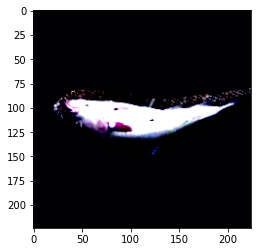

In [10]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[13][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


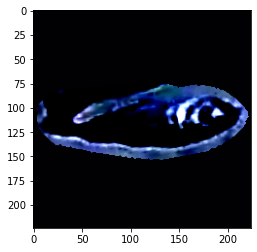

In [11]:
plt.imshow(val_dataset[13][0].permute(1, 2, 0))

In [12]:
train_dataset = Subset(train_dataset, indices=train_sour_idx)
train_dataset2 = Subset(train_dataset2, indices=valid_sour_idx)

In [13]:
def getSampler(labels):
    class_sample_count = np.unique(labels, return_counts=True)[1]
    class_weights = 1./torch.tensor(class_sample_count, dtype=torch.float) 
    class_weights_all = class_weights[labels]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )
    return sampler

In [14]:
sour_train_labels = []
for train_index in train_dataset.indices:
    sour_train_labels.append(train_dataset.dataset.imgs[train_index][1])
sour_train_labels = torch.tensor(sour_train_labels)
sour_sampler = getSampler(sour_train_labels)

In [15]:
sour_train_dl = DataLoader(train_dataset, shuffle=False, batch_size=64, sampler=sour_sampler, num_workers = 1)
sour_val_dl = DataLoader(train_dataset2, batch_size=32*2, num_workers = 1, pin_memory = True)
targ_train_dl = DataLoader(val_dataset, batch_size=32*2, num_workers = 1, pin_memory = True)

In [19]:
#check sampler
# subset_index = []
# for i, j in sour_train_dl:
#     subset_index = np.concatenate((subset_index, j.numpy()), axis=None)
# a = np.unique(subset_index, return_counts=True)
# a

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([578, 607, 624, 648, 612, 590, 612, 611, 672, 615, 640, 644, 604]))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
student = torchvision.models.resnet152(pretrained=True)
student.fc = nn.Sequential(
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024,13)
)

In [18]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)
    

In [19]:
import torch
device = get_default_device()
device

device(type='cuda')

In [20]:
student = to_device(student, device)

In [21]:
sour_train_dl = DeviceDataLoader(sour_train_dl, device)
targ_train_dl = DeviceDataLoader(targ_train_dl, device)
sour_val_dl = DeviceDataLoader(sour_val_dl, device)

In [22]:
log_file = "TrainTargetOnly_logfile_03"
def logfile(text):
    print(text)
    if log_file is not None:
        with open(log_file, 'a') as f:
            f.write(text + '\n')
            f.flush()
            f.close()
logfile("resnet 152 pretrain and 4 data argumentation remove color jitter learning rate 10-5,")

resnet 152 pretrain and 4 data argumentation remove color jitter learning rate 10-5,


In [23]:
@torch.no_grad()
def train_pred(X_sup):
    student.eval()
    return F.softmax(student(X_sup), dim=1).detach().cpu().numpy()

@torch.no_grad()
def f_eval_src(val_dl,num):

    stu_num = 0
    for X_sup, y_sup in val_dl:

        y_pred_prob_stu = train_pred(X_sup)
        y_pred_stu = np.argmax(y_pred_prob_stu, axis=1)

        stu_num += float((y_pred_stu != y_sup.cpu().numpy()).sum())
    return stu_num/num

In [24]:
epochs = 100
opt_func = torch.optim.Adam
lr = 0.00001

optimizer = opt_func(student.parameters(),lr)

import time

loss_his1 = []

log=[]
log1=[]

for epoch in range(epochs):

    t1 = time.time()
    
    student.train()
    train_losses = []
    conf_mask_counts = 0
    
    for batch in sour_train_dl:
        
        X_src, y_src = batch
        src_logits_out = student(X_src)
        loss = F.cross_entropy(src_logits_out, y_src)
        
        train_losses.append(loss)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    log.append(f_eval_src(targ_train_dl,len(val_dataset)))
    log1.append(f_eval_src(sour_val_dl,len(train_dataset2)))

    loss_his1.append(torch.stack(train_losses).mean().item())
    
    t2 = time.time()
                                                 
    logfile('Epoch {} took {:.2f}s: TRAIN clf loss={:.6f},'
        'source dataset student ERR={:.6%}, target dataset student ERR={:.6%},'.format(
         epoch, t2 - t1, loss_his1[epoch], log1[epoch], log[epoch]))  
    
    if epoch%20 == 0 and epoch != 0:
        model_name = "TrainSourceOnly02"
        torch.save(student.state_dict(), model_name + "student")
        #torch.save(teacher.state_dict(), model_name + "teacher")
    

Epoch 0 took 680.96s: TRAIN clf loss=2.308882,source dataset student ERR=59.850000%, target dataset student ERR=67.411642%,
Epoch 1 took 650.91s: TRAIN clf loss=1.203745,source dataset student ERR=57.950000%, target dataset student ERR=56.382536%,
Epoch 2 took 652.30s: TRAIN clf loss=0.700045,source dataset student ERR=43.250000%, target dataset student ERR=48.253638%,
Epoch 3 took 645.37s: TRAIN clf loss=0.514572,source dataset student ERR=36.450000%, target dataset student ERR=41.850312%,
Epoch 4 took 646.25s: TRAIN clf loss=0.421756,source dataset student ERR=26.200000%, target dataset student ERR=41.632017%,
Epoch 5 took 650.23s: TRAIN clf loss=0.348593,source dataset student ERR=22.900000%, target dataset student ERR=39.573805%,
Epoch 6 took 658.27s: TRAIN clf loss=0.318202,source dataset student ERR=24.500000%, target dataset student ERR=38.711019%,
Epoch 7 took 634.90s: TRAIN clf loss=0.271924,source dataset student ERR=20.550000%, target dataset student ERR=37.525988%,
Epoch 8 

KeyboardInterrupt: 